# Lab 2.2: Human-in-the-Loop (HITL) Basics

In this lab, we will learn how to pause execution of a graph to allow for human intervention.

## Key Concepts
1. **Interrupts**: `interrupt_before` or `interrupt_after` a specific node.
2. **State Inspection**: Viewing the current state while the graph is paused.
3. **State Update**: Modifying the state manually before resuming.
4. **Resuming**: Continuing execution from the paused state.

In [ ]:
# 1. Install Dependencies
%pip install -qU langchain-groq langchain-community langgraph

In [1]:
# 2. Setup API Keys
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API Key: ")

## 3. Define Graph with Interrupt
We will make a simple 2-step graph: `node_1` -> `node_2`.
We will interrupt before `node_2`.

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Simple state
class State(TypedDict):
    input: str
    step_1_output: str
    final_output: str

def node_1(state: State):
    print("--- Executing Node 1 ---")
    return {"step_1_output": f"Processed '{state['input']}' at step 1"}

def node_2(state: State):
    print("--- Executing Node 2 ---")
    return {"final_output": f"Finalized: {state['step_1_output']}"}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Checkpointer is REQUIRED for interrupts
memory = MemorySaver()

# Interrupt before node_2
graph = builder.compile(checkpointer=memory, interrupt_before=["node_2"])

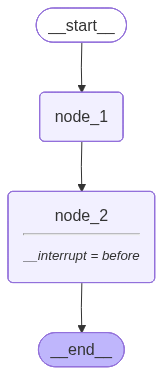

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies; ignore if it fails in basic environment
    pass

## 4. Run until Interrupt
We start the graph. It should stop after `node_1`.

In [3]:
thread_config = {"configurable": {"thread_id": "hitl-demo-1"}}

# Initial run
result = graph.invoke({"input": "Hello World"}, config=thread_config)

print("Is graph finished?", result is not None)

--- Executing Node 1 ---
Is graph finished? True


The output is `None` (or partial state depending on version) because it paused. Let's inspect the state.

In [4]:
current_state = graph.get_state(thread_config)
print("Next node:", current_state.next)
print("Current values:", current_state.values)

Next node: ('node_2',)
Current values: {'input': 'Hello World', 'step_1_output': "Processed 'Hello World' at step 1"}


## 5. Modify State (Human Intervention)
Let's change `step_1_output` before proceeding.

In [5]:
graph.update_state(
    thread_config,
    {"step_1_output": "HUMAN OVERRIDE!"}
)

# Verify update
print("Updated values:", graph.get_state(thread_config).values)

Updated values: {'input': 'Hello World', 'step_1_output': 'HUMAN OVERRIDE!'}


## 6. Resume Execution
We call `invoke` (or `stream`) with `None` as input to resume.

In [6]:
final_result = graph.invoke(None, config=thread_config)
print("Final Output:", final_result["final_output"])

--- Executing Node 2 ---
Final Output: Finalized: HUMAN OVERRIDE!
